<h1>Distributed Federated Learning with MNIST Data</h1>

<b>Importing the libraries</b>

<ul>
<li> Pytorch (to train the model)
<li> Pysyft (to train using federated approach)
</ul>

In [1]:
import pickle
import itertools
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import syft as sy
from syft.frameworks.torch.fl import utils
import pandas as pd
import itertools
import random
import datetime

In [2]:
class Parser:
     def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 100
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False
        self.num_of_workers = 3
    
args = Parser()
torch.manual_seed(args.seed)
kwargs = {'num_workers': 1, 'pin_memory': False}

<b>Download MNIST Data using torchvision datasets module</b>

In [3]:
train_loader = DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    #.federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=1, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

<b>Creating architecture of the Neural Network model</b>

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def federated_avg(self, neighbour_model_params=None, current_worker=None):
        #Average two models weights
        
        params1 = self.state_dict()
        params2 = neighbour_model_params #neighbour_model_params.copy()
      
        with torch.no_grad():
            for name1 in params1:
                if name1 in params2:
                    neighbour_ptr = params2[name1].copy()
                    neighbour_ptr.move(current_worker)
                    #print(current_worker, neighbour_ptr)
                    params1[name1] = (params1[name1]  + neighbour_ptr)/2
        
                    
        self.load_state_dict(params1, strict=False)
        
    def federated_avg_multi(self, neighbour_model_params, current_worker=None):
        
        if len(neighbour_model_params) == 1:
            self.federated_avg(neighbour_model_params[0], current_worker)
        else:
            params1 = self.state_dict()
            for params2 in neighbour_model_params: 
                #params2 = neighbour_model_params #neighbour_model_params.copy()
                with torch.no_grad():
                    for name1 in params1:
                        if name1 in params2:
                            neighbour_ptr = params2[name1].copy()
                            neighbour_ptr.move(current_worker)
                    #print(current_worker, neighbour_ptr)
                            params1[name1] = params1[name1]  + neighbour_ptr
            
            #Averaging model weights
            scale = len(neighbour_model_params) + 1
            with torch.no_grad():
                for name in params1:
                    #print("#######param  ", name)
                    params1[name] = params1[name] / scale
                
            #Load back new params to model        
            self.load_state_dict(params1, strict=False)
        
    

In [5]:
#Create events list for virutal workers exchange of parameters.
def create_events(num_of_workers):
    worker_events = list(itertools.combinations(range(1,num_of_workers+1),2))
    random.shuffle(worker_events)
    
    events_df = pd.DataFrame(worker_events,columns=['worker_id1','worker_id2'])
    events_df.index.names = ["batchnum"]
    return events_df

In [6]:
events_df = create_events(args.num_of_workers)
events_df

,worker_id1,worker_id2
batchnum,,
0,2,3
1,1,2
2,1,3


<b>Initilizer Function to create Virtual workers, initiate models and optimizers. Data will split amongst workers and trained.</b>

In [7]:
def initialize_workers():
    hook = sy.TorchHook(torch)
    compute_nodes = [sy.VirtualWorker(hook, id=f"worker-{i}") for i in range(args.num_of_workers)]
    remote_dataset = tuple(list() for _ in range(args.num_of_workers))
    input_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_counter = {}
    ##target_worker_split = {0:0, 1:1, 2:(2,0), 3:1, 4:0, 5:1, 6:2, 7:1, 8:(2,0), 9:2 }  ##target values for 3 workers
    #target_worker_split = {0:0, 1:1, 2:0, 3:1, 4:(1,0), 5:(1,0), 6:(0,1), 7:1, 8:(0,1), 9:0 }    ##target values for 2 workers
    target_worker_split = {0:0, 1:1, 2:2, 3:0, 4:2, 5:1, 6:2, 7:0, 8:1, 9:2 }
    
    for batch_idx, (data,target) in enumerate(train_loader):
        target_value = target.item()
        
        if isinstance(target_worker_split[target_value], tuple):
            current_worker_idx = target_worker_split[target_value][0]
            target_worker_split[target_value] = tuple(reversed(target_worker_split[target_value]))
        else:
            current_worker_idx = target_worker_split[target.item()]
        
        if len(target_worker_dataset[current_worker_idx]) == args.batch_size:
            input_data , target_values = list(zip(*target_worker_dataset[current_worker_idx]))
            target_values = torch.cat(target_values)
            input_data = torch.cat(input_data)
            remote_data = input_data.send(compute_nodes[current_worker_idx])
            remote_target = target_values.send(compute_nodes[current_worker_idx])
            remote_dataset[current_worker_idx].append((remote_data, remote_target))
            target_worker_dataset[current_worker_idx] = list()
            
        
        target_worker_dataset[current_worker_idx].append((data, target))
            
        
    models = [Net() for _ in range(args.num_of_workers)]
    optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
    return compute_nodes, remote_dataset, models, optimizers


In [8]:
def update(data, target, model, optimizer):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    return model

In [9]:
def exchange_parameters(models, data_index):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    event_idx = data_index % len(events_df)
    event_row = events_df.loc[[event_idx]]
    worker_id1 = event_row['worker_id1'].values[0]-1
    worker_id2 = event_row['worker_id2'].values[0]-1
    worker1_model = models[worker_id1]
    worker2_model = models[worker_id2]
    worker1_params = worker1_model.state_dict()
    worker2_params = worker2_model.state_dict()
    
    #Send worker2 params to worker1 for averaging at worker1
    worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
    
    #Send worker1 params to worker2 for averaging at worker2
    worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])

def exchange_parameters_multiple(models, data_index=None):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    #current_worker_idx = data_index % len(compute_nodes)
    #worker1_model = models[current_worker_idx]
    #worker1_params = worker1_model.state_dict().copy()
    worker_params = [model.state_dict().copy() for model in models]
    idx = 0
    
    for node in compute_nodes:
        other_worker_params = [param for i, param in enumerate(worker_params) if i != idx ]
        models[idx].federated_avg_multi(other_worker_params, compute_nodes[idx])
        idx += 1
    
        
    
    ##Copy the model to other workers
    #new_models = [] #[worker1_model.copy().move(node) for i, node in enumerate(compute_nodes) if i != current_worker_idx]
    #for i, node in enumerate(compute_nodes):
    #    if i == current_worker_idx:
    #        print("###CURRENT######", type(worker1_model), node, worker1_model)
    #        new_models.append(worker1_model)
    #    else:
    #        neighbour_model_ptr = worker1_model.copy()
    #        print("###other######", type(neighbour_model_ptr), node, worker1_model.location, neighbour_model_ptr)
    #        neighbour_model_ptr.move(node)
    #        new_models.append(neighbour_model_ptr)
    #        print("###After mive######", type(neighbour_model_ptr), node, neighbour_model_ptr)
    
    #return new_models
    
   

In [10]:
def train(models, compute_nodes, remote_dataset, optimizers, epoch_id, federated_average=False, exchange=False):
    
    if federated_average:
        models = [models.copy() for _ in range(args.num_of_workers)]
        optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
        
    models = [model.send(compute_nodes[i]) for i, model in enumerate(models)]
    

    
    for remote_index in range(len(compute_nodes)):
        #print(f"Trip {data_index} and length of remote_dataset in {len(remote_dataset[0])} {len(remote_dataset[1])} {len(remote_dataset[2])}")
        for data_index in range(len(remote_dataset[remote_index])):
            data, target = remote_dataset[remote_index][data_index]
            models[remote_index] = update(data, target, models[remote_index], optimizers[remote_index])
        
    #Exchange of parameter between two remote models.
    if exchange:
        #exchange_parameters(models, epoch_id)
        exchange_parameters_multiple(models, epoch_id)
  
        
    for model in models:
        model.get()
        
    
    #if exchange:
    #    return models
        
    #Federated Average
    if federated_average:
        model =  utils.federated_avg({f"worker-{i}":models[i] for i in range(len(compute_nodes))})
        return model

In [11]:
def test(federated_model, worker_id):
    federated_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = federated_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            prediction = output.argmax(1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()
           
        
    test_loss /= len(test_loader.dataset)
    avg_correct = correct / len(test_loader.dataset)
    print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_id, test_loss, avg_correct))
    return test_loss, avg_correct
    

In [12]:
def run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=False):
    model = Net()
    
    eval_results = []
    for epoch in range(args.epochs):
        start_time = time.time()
        print(f"Epoch Number {epoch + 1}")
        

        if exchange:
            #models = train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
        elif federated_average:
            
            federated_model = train(model, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            avg_loss, avg_accuracy = test(federated_model, "federated_avg_local")
            results = {"worker_id" : "federated_avg_local",
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
            eval_results.append(results)
            model = federated_model
        else:
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
            
        total_time = time.time() - start_time
        print('Communication time over the network', round(total_time, 2), 's\n')
    return eval_results

###  Simulation with training on individual workers on their local data

In [13]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
individual_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-03-01 20:16:46.044024
Epoch Number 1
Test set for worker worker-0: Average loss: 8.0698 & Average Accuracy : 0.2969
Test set for worker worker-1: Average loss: 8.5712 & Average Accuracy : 0.2907
Test set for worker worker-2: Average loss: 6.4508 & Average Accuracy : 0.3825
Communication time over the network 80.48 s

Epoch Number 2
Test set for worker worker-0: Average loss: 8.5670 & Average Accuracy : 0.2984
Test set for worker worker-1: Average loss: 9.2313 & Average Accuracy : 0.2940
Test set for worker worker-2: Average loss: 6.5208 & Average Accuracy : 0.3871
Communication time over the network 78.68 s

Epoch Number 3
Test set for worker worker-0: Average loss: 8.7468 & Average Accuracy : 0.2988
Test set for worker worker-1: Average loss: 9.4259 & Average Accuracy : 0.2948
Test set for worker worker-2: Average loss: 6.5030 & Average Accuracy : 0.3900
Communication time over the network 80.27 s

Epoch Number 4
Test set for worker worker-0: Average loss: 8.8464 & Ave

Test set for worker worker-2: Average loss: 7.9940 & Average Accuracy : 0.3960
Communication time over the network 79.41 s

Epoch Number 29
Test set for worker worker-0: Average loss: 10.4898 & Average Accuracy : 0.3010
Test set for worker worker-1: Average loss: 11.0107 & Average Accuracy : 0.2983
Test set for worker worker-2: Average loss: 8.0516 & Average Accuracy : 0.3961
Communication time over the network 79.22 s

Epoch Number 30
Test set for worker worker-0: Average loss: 10.5545 & Average Accuracy : 0.3010
Test set for worker worker-1: Average loss: 11.0858 & Average Accuracy : 0.2983
Test set for worker worker-2: Average loss: 8.1042 & Average Accuracy : 0.3961
Communication time over the network 78.8 s

Epoch Number 31
Test set for worker worker-0: Average loss: 10.6250 & Average Accuracy : 0.3010
Test set for worker worker-1: Average loss: 11.1623 & Average Accuracy : 0.2984
Test set for worker worker-2: Average loss: 8.1739 & Average Accuracy : 0.3961
Communication time ove

Test set for worker worker-0: Average loss: 12.3586 & Average Accuracy : 0.3011
Test set for worker worker-1: Average loss: 12.5225 & Average Accuracy : 0.2992
Test set for worker worker-2: Average loss: 9.5787 & Average Accuracy : 0.3962
Communication time over the network 79.18 s

Epoch Number 57
Test set for worker worker-0: Average loss: 12.4324 & Average Accuracy : 0.3011
Test set for worker worker-1: Average loss: 12.5704 & Average Accuracy : 0.2992
Test set for worker worker-2: Average loss: 9.6335 & Average Accuracy : 0.3962
Communication time over the network 79.39 s

Epoch Number 58
Test set for worker worker-0: Average loss: 12.5050 & Average Accuracy : 0.3011
Test set for worker worker-1: Average loss: 12.6146 & Average Accuracy : 0.2992
Test set for worker worker-2: Average loss: 9.6779 & Average Accuracy : 0.3961
Communication time over the network 79.83 s

Epoch Number 59
Test set for worker worker-0: Average loss: 12.5775 & Average Accuracy : 0.3011
Test set for worker 

Test set for worker worker-1: Average loss: 13.5527 & Average Accuracy : 0.2995
Test set for worker worker-2: Average loss: 10.8125 & Average Accuracy : 0.3963
Communication time over the network 87.73 s

Epoch Number 84
Test set for worker worker-0: Average loss: 14.0363 & Average Accuracy : 0.3012
Test set for worker worker-1: Average loss: 13.5861 & Average Accuracy : 0.2995
Test set for worker worker-2: Average loss: 10.8531 & Average Accuracy : 0.3963
Communication time over the network 82.02 s

Epoch Number 85
Test set for worker worker-0: Average loss: 14.0844 & Average Accuracy : 0.3012
Test set for worker worker-1: Average loss: 13.6158 & Average Accuracy : 0.2995
Test set for worker worker-2: Average loss: 10.8903 & Average Accuracy : 0.3963
Communication time over the network 79.86 s

Epoch Number 86
Test set for worker worker-0: Average loss: 14.1305 & Average Accuracy : 0.3012
Test set for worker worker-1: Average loss: 13.6459 & Average Accuracy : 0.2995
Test set for work

###  Simulation with training  with federated average

In [14]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=True, exchange=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-03-01 22:32:47.996374
Epoch Number 1
Test set for worker federated_avg_local: Average loss: 1.6599 & Average Accuracy : 0.4971
Communication time over the network 81.44 s

Epoch Number 2
Test set for worker federated_avg_local: Average loss: 0.9662 & Average Accuracy : 0.7234
Communication time over the network 74.28 s

Epoch Number 3
Test set for worker federated_avg_local: Average loss: 0.6668 & Average Accuracy : 0.8124
Communication time over the network 77.93 s

Epoch Number 4
Test set for worker federated_avg_local: Average loss: 0.5304 & Average Accuracy : 0.8448
Communication time over the network 75.35 s

Epoch Number 5
Test set for worker federated_avg_local: Average loss: 0.4411 & Average Accuracy : 0.8703
Communication time over the network 79.22 s

Epoch Number 6
Test set for worker federated_avg_local: Average loss: 0.3772 & Average Accuracy : 0.8895
Communication time over the network 76.8 s

Epoch Number 7
Test set for worker federated_avg_local: Average

Test set for worker federated_avg_local: Average loss: 0.0871 & Average Accuracy : 0.9725
Communication time over the network 70.76 s

Epoch Number 56
Test set for worker federated_avg_local: Average loss: 0.0866 & Average Accuracy : 0.9725
Communication time over the network 70.6 s

Epoch Number 57
Test set for worker federated_avg_local: Average loss: 0.0860 & Average Accuracy : 0.9727
Communication time over the network 71.16 s

Epoch Number 58
Test set for worker federated_avg_local: Average loss: 0.0856 & Average Accuracy : 0.9727
Communication time over the network 70.72 s

Epoch Number 59
Test set for worker federated_avg_local: Average loss: 0.0849 & Average Accuracy : 0.9730
Communication time over the network 70.78 s

Epoch Number 60
Test set for worker federated_avg_local: Average loss: 0.0846 & Average Accuracy : 0.9734
Communication time over the network 70.67 s

Epoch Number 61
Test set for worker federated_avg_local: Average loss: 0.0839 & Average Accuracy : 0.9737
Commu

###  Simulation with training  with Decentralized federated average

In [15]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
decentrailized_fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=True)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")  

Start time 2021-03-02 00:32:20.758967
Epoch Number 1
Test set for worker worker-0: Average loss: 2.2566 & Average Accuracy : 0.1016
Test set for worker worker-1: Average loss: 2.2593 & Average Accuracy : 0.1495
Test set for worker worker-2: Average loss: 2.2296 & Average Accuracy : 0.3511
Communication time over the network 78.9 s

Epoch Number 2
Test set for worker worker-0: Average loss: 1.7234 & Average Accuracy : 0.3829
Test set for worker worker-1: Average loss: 2.2724 & Average Accuracy : 0.4568
Test set for worker worker-2: Average loss: 2.7016 & Average Accuracy : 0.3734
Communication time over the network 79.44 s

Epoch Number 3
Test set for worker worker-0: Average loss: 1.1872 & Average Accuracy : 0.6259
Test set for worker worker-1: Average loss: 2.0938 & Average Accuracy : 0.6127
Test set for worker worker-2: Average loss: 2.5595 & Average Accuracy : 0.3916
Communication time over the network 78.26 s

Epoch Number 4
Test set for worker worker-0: Average loss: 0.9432 & Aver

Test set for worker worker-2: Average loss: 0.4196 & Average Accuracy : 0.8558
Communication time over the network 79.13 s

Epoch Number 29
Test set for worker worker-0: Average loss: 0.1476 & Average Accuracy : 0.9538
Test set for worker worker-1: Average loss: 0.3428 & Average Accuracy : 0.8787
Test set for worker worker-2: Average loss: 0.4141 & Average Accuracy : 0.8572
Communication time over the network 78.6 s

Epoch Number 30
Test set for worker worker-0: Average loss: 0.1451 & Average Accuracy : 0.9548
Test set for worker worker-1: Average loss: 0.3367 & Average Accuracy : 0.8809
Test set for worker worker-2: Average loss: 0.4081 & Average Accuracy : 0.8586
Communication time over the network 78.82 s

Epoch Number 31
Test set for worker worker-0: Average loss: 0.1427 & Average Accuracy : 0.9552
Test set for worker worker-1: Average loss: 0.3295 & Average Accuracy : 0.8832
Test set for worker worker-2: Average loss: 0.4021 & Average Accuracy : 0.8614
Communication time over the 

Test set for worker worker-1: Average loss: 0.2388 & Average Accuracy : 0.9132
Test set for worker worker-2: Average loss: 0.3257 & Average Accuracy : 0.8892
Communication time over the network 78.43 s

Epoch Number 57
Test set for worker worker-0: Average loss: 0.1104 & Average Accuracy : 0.9642
Test set for worker worker-1: Average loss: 0.2356 & Average Accuracy : 0.9144
Test set for worker worker-2: Average loss: 0.3223 & Average Accuracy : 0.8902
Communication time over the network 78.46 s

Epoch Number 58
Test set for worker worker-0: Average loss: 0.1096 & Average Accuracy : 0.9646
Test set for worker worker-1: Average loss: 0.2340 & Average Accuracy : 0.9152
Test set for worker worker-2: Average loss: 0.3206 & Average Accuracy : 0.8909
Communication time over the network 78.49 s

Epoch Number 59
Test set for worker worker-0: Average loss: 0.1090 & Average Accuracy : 0.9650
Test set for worker worker-1: Average loss: 0.2320 & Average Accuracy : 0.9163
Test set for worker worker-

Test set for worker worker-0: Average loss: 0.0993 & Average Accuracy : 0.9675
Test set for worker worker-1: Average loss: 0.1995 & Average Accuracy : 0.9315
Test set for worker worker-2: Average loss: 0.2748 & Average Accuracy : 0.9072
Communication time over the network 79.5 s

Epoch Number 85
Test set for worker worker-0: Average loss: 0.0989 & Average Accuracy : 0.9678
Test set for worker worker-1: Average loss: 0.1990 & Average Accuracy : 0.9315
Test set for worker worker-2: Average loss: 0.2731 & Average Accuracy : 0.9075
Communication time over the network 79.18 s

Epoch Number 86
Test set for worker worker-0: Average loss: 0.0989 & Average Accuracy : 0.9676
Test set for worker worker-1: Average loss: 0.1985 & Average Accuracy : 0.9319
Test set for worker worker-2: Average loss: 0.2730 & Average Accuracy : 0.9075
Communication time over the network 78.58 s

Epoch Number 87
Test set for worker worker-0: Average loss: 0.0987 & Average Accuracy : 0.9677
Test set for worker worker-1

In [16]:
ind_train_df = pd.DataFrame(individual_train_results)
ind_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,8.069844,0.2969
1,worker-1,0,8.571244,0.2907
2,worker-2,0,6.450829,0.3825
3,worker-0,1,8.567019,0.2984
4,worker-1,1,9.231328,0.2940
...,...,...,...,...
295,worker-1,98,13.997584,0.2995
296,worker-2,98,11.352365,0.3963
297,worker-0,99,14.711757,0.3012
298,worker-1,99,14.025574,0.2995


In [17]:
fedavg_train_df = pd.DataFrame(fedavg_train_results)
fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,federated_avg_local,0,1.659933,0.4971
1,federated_avg_local,1,0.966177,0.7234
2,federated_avg_local,2,0.666760,0.8124
3,federated_avg_local,3,0.530375,0.8448
4,federated_avg_local,4,0.441133,0.8703
...,...,...,...,...
95,federated_avg_local,95,0.073628,0.9768
96,federated_avg_local,96,0.073446,0.9770
97,federated_avg_local,97,0.073233,0.9770
98,federated_avg_local,98,0.073156,0.9769


In [18]:
decentrailized_fedavg_train_df = pd.DataFrame(decentrailized_fedavg_train_results)
decentrailized_fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,2.256630,0.1016
1,worker-1,0,2.259328,0.1495
2,worker-2,0,2.229568,0.3511
3,worker-0,1,1.723359,0.3829
4,worker-1,1,2.272411,0.4568
...,...,...,...,...
295,worker-1,98,0.191514,0.9365
296,worker-2,98,0.264257,0.9131
297,worker-0,99,0.097480,0.9685
298,worker-1,99,0.190107,0.9371


### Plot Graph for Individual worker training accuracy over time.

In [19]:
#%matplotlib inline
#for key, grp in ind_train_df.groupby(['worker_id']):
#    grp.plot(x="epoch_idx", y="avg_accuracy", label=key, ylabel="avg_accuracy")



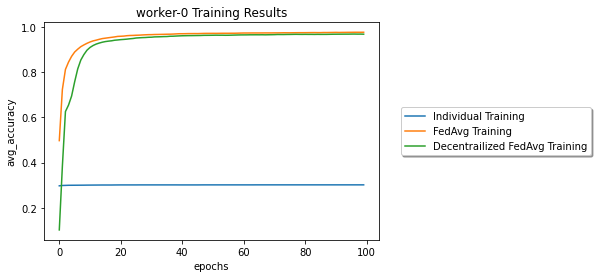

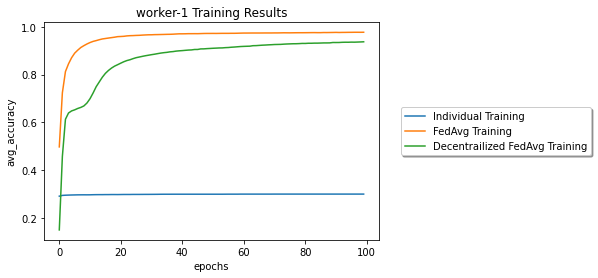

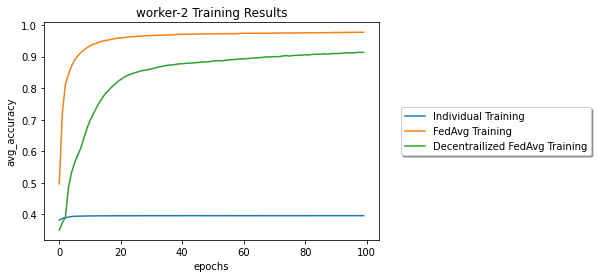

In [20]:
%matplotlib inline
ind_train_df
fedavg_train_df
decentrailized_fedavg_train_df
for node in compute_nodes:
    ind_worker_data  = ind_train_df[ind_train_df['worker_id']==node.id]
    plt.plot(ind_worker_data['epoch_idx'],ind_worker_data['avg_accuracy'], label="Individual Training")

    plt.plot(fedavg_train_df['epoch_idx'],fedavg_train_df['avg_accuracy'], label="FedAvg Training")
    
    decentral_worker_data  = decentrailized_fedavg_train_df[decentrailized_fedavg_train_df['worker_id']==node.id]
    plt.plot(decentral_worker_data['epoch_idx'],decentral_worker_data['avg_accuracy'], label="Decentrailized FedAvg Training")
    
    plt.xlabel('epochs')
    # Set the y axis label of the current axis.
    plt.ylabel('avg_accuracy')
    # Set a title of the current axes.
    plt.title(f'{node.id} Training Results')
    # show a legend on the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), shadow=True)
    # Display a figure.
    plt.show()